# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



# IMPORTANT: Make sure the temperature (set below) matches the temperature you used to run the simulations.

In [1]:
import warnings
import logging
import copy
import matplotlib as mpl
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

logging.captureWarnings(True)
warnings.simplefilter(action='ignore', category=FutureWarning)
#logger = logging.getLogger("alchemlyb.parsers.NAMD")
logging.disable(level='CRITICAL')

from helpers import *

In [2]:
def checkPaths(paths, nDone):
    goodpaths = []
    for path in paths:
        feps = glob(path+pattern)
        countDone = 0
        for fep in feps:
            with open(fep) as f:
                if 'Free' in f.read():
                    countDone+=1
        if countDone == nDone:
            goodpaths.append(path)
    
    return goodpaths

In [3]:
temperature = 303.15
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

In [4]:
## Membranes
root = '../../protein_systems/'
systems = ['ELIC5', 'WT']
longSysNames = {'ELIC5':'5 Mutant', 'WT':'Wild Type'}

prefixes = ['PE_to_PC', 'PC_to_PG', 'PE_to_PG']
longNames = {'PC_to_PG':'POPC to POPG', 'PE_to_PG':'POPE to POPG', 'PE_to_PC':'POPE to POPC'}

lambdas = np.round(np.linspace(0,1,41),5)

pattern = 'p*fepout'
checkReplicas = False

In [5]:
allSys = {}

reread = False

for sys in systems:
    path = root+sys+'/'
    
    if not reread:
        try:
            system = loadSystem(path)
            print(f"Read saved {sys} from {path}")
        except:
            print("Failed to read saved file. Parsing FEPOUTS.")
            system = processAllLegs(path, prefixes, pattern, lambdas, temperature, RT, decorrelate, detectEQ, postfix='/')
            saveSystem(system, path)
    else:
        system = processAllLegs(path, prefixes, pattern, lambdas, temperature, RT, decorrelate, detectEQ, postfix='/')
        saveSystem(system, path)
    allSys[sys] = system

Read saved ELIC5 from ../../protein_systems/ELIC5/
Read saved WT from ../../protein_systems/WT/


In [6]:
for sys in systems:
    for key in allSys[sys].keys():
        try:
            allSys[sys][key].columns = allSys[sys][key].columns.droplevel(1)
        except:
            continue

In [7]:
def cumulativePlot(system, leg, keys, keyColors, theax):
    cumulative = system['cumulatives'][leg]
    X = cumulative.index
    for key in keys:
        Y = cumulative[(key, 'f')]*RT
        theColor = keyColors[key]
        theax.plot(X, Y, marker=None, label=key, linewidth=1, color=theColor)
        #finalMean = cumulative.loc[1].iloc[0]*RT
        finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(finalMean*RT, color='gray', linestyle='-.', linewidth=1)
    
    return theax









    




    



def makePlots(allSys, systems, prefixes, xlabel, ylabel, doPlot, sharey=True, sharex=True, sameAx=False, masterColors=['#0072B2', '#D55E00', '#CC79A7', '#009E73', '#E69F00']):
    if sameAx:
        fig, theaxes = plt.subplots(3,1, sharex=sharex, sharey=sharey)
    else:
        fig, theaxes = plt.subplots(3,len(systems), sharex=sharex, sharey=sharey)
    pad = 5 # in points
    
    for prefID in np.arange(len(prefixes)):
        leg = prefixes[prefID]
        if sameAx:
            theaxes[2].set(xlabel=xlabel)
            #theaxes[0].annotate(sysName, xy=(0.5, 1), xytext=(0, pad),
                    #xycoords='axes fraction', textcoords='offset points',
                    #size='large', ha='center', va='baseline')
            theax = doPlot(allSys, systems, leg, masterColors, theaxes[prefID])
            theaxes[prefID].set(ylabel=ylabel)
            theaxes[prefID].annotate(longNames[leg], xy=(0, 0.5), xytext=(-theaxes[prefID].yaxis.labelpad - pad, 0),
                xycoords=theaxes[prefID].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
            theaxes[0].legend()
            
            fig.set_figheight(6)
            fig.set_figwidth(3)
        
        else:
            fig.set_figheight(len(systems)*10.0/3.0)
            fig.set_figwidth(len(systems)*8.0/3)
            for sysID in np.arange(len(systems)):
                
                sysName = systems[sysID]
                system = allSys[sysName]
                print(f'Now making figures for: {sysName}')

                theaxes[2, sysID].set(xlabel=xlabel)
                theaxes[0, sysID].annotate(sysName, xy=(0.5, 1), xytext=(0, pad),
                        xycoords='axes fraction', textcoords='offset points',
                        size='large', ha='center', va='baseline')

                try:
                    keys = system['keyColors'][leg].keys()
                    keyColors = system['keyColors'][leg]

                    theaxes[prefID, 0].set(ylabel=ylabel)
                    theaxes[prefID, 0].annotate(longNames[leg], xy=(0, 0.5), xytext=(-theaxes[prefID, 0].yaxis.labelpad - pad, 0),
                        xycoords=theaxes[prefID, 0].yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)
                    theax = doPlot(system, leg, keys, keyColors, theaxes[prefID, sysID])
                except:
                    print("An error occured. Do you have bogus 'replicas'?")
                    raise
                    continue
            

        

    fig.tight_layout()
    
    return fig, theaxes

def colorKey(system, leg, keys, keyColors, theax):
    X = 0
    Y = 0
    width = 0.5
    height = 0.5
    for key in keys:
        print(key)
        if keyColors[key]:
            patch = mpl.patches.Rectangle((X,Y),width, height, edgecolor=keyColors[key], linewidth=None, facecolor=keyColors[key])
            theax.add_patch(patch)
            Y += height
            theax.text(0, Y-height/len(keys), key)
    
    theax.set(ylim=(0,Y), yticks=[], xticks=[])

    return theax


In [8]:

def sharedCumulativePlot(allSys, systems, leg, colors, theax):
    for sysID in np.arange(len(systems)):
        sysName = systems[sysID]
        system = allSys[sysName]
        cumulative = system['cumulatives'][leg]
        X = cumulative.index
        
        Y = cumulative['f']*RT
        theColor = colors[sysID]
        theax.plot(X, Y, marker=None, label=sysName, linewidth=1, color=theColor)
        #finalMean = cumulative.loc[1].iloc[0]*RT
        finalMean = np.mean(cumulative.loc[1, 'f'])
        theax.axhline(finalMean*RT, color=colors[sysID], linestyle='-.', linewidth=1)
    
    return theax

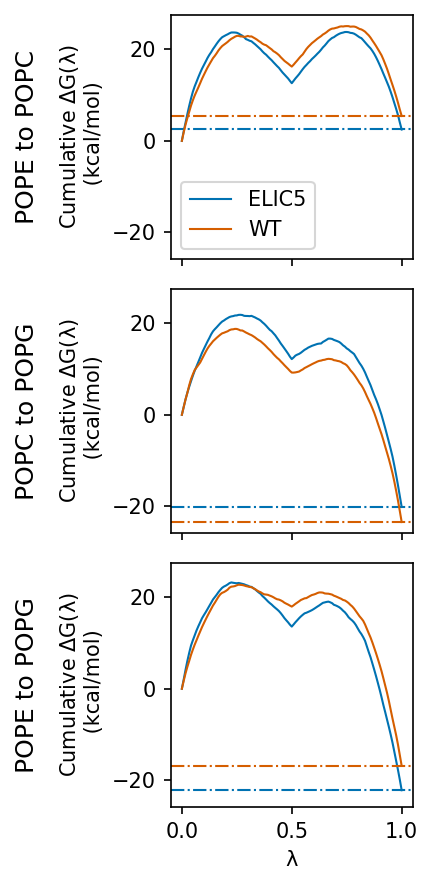

In [9]:
fig, dGaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'Cumulative $\rm\Delta$G($\rm\lambda$)'+'\n (kcal/mol)', doPlot=sharedCumulativePlot, sameAx=True)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_sameAx_S4.pdf")

In [10]:
trimmed=copy.deepcopy(allSys)

fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=None, ylabel=None, doPlot=colorKey, sharey=False)
plt.savefig(f"{root}/Protein_DRAFT_colorKey.pdf")

In [13]:
def sharedHystPDF(allSys, systems, leg, colors, theax):
    for sysID in np.arange(len(systems)):
        sysName = systems[sysID]
        print(f'Now making figures for: {sysName}')
        system = allSys[sysName]
        perWindow = system['perWins'][leg]
        # Hysteresis PDF
        diff = perWindow.loc[:, 'diff']*RT
        try:
            X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
        except:
            X = diff
        Y = np.arange(len(X))/len(X)
        binNum = 20
        pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
        pdfX = (pdfX[1:]+pdfX[:-1])/2


        #plot the data
        theax.plot(pdfX, pdfY,  color=colors[sysID], label=sysName)
    theax.set(xlim=(-1.25, 1.25))
    
    return theax

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


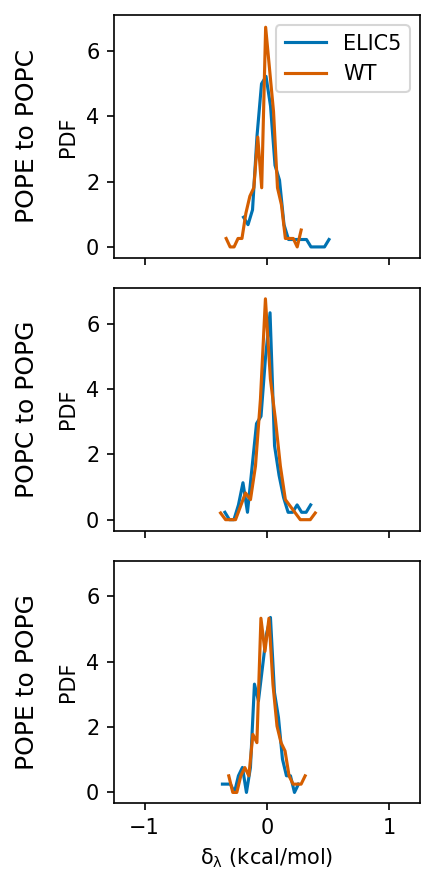

In [14]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', ylabel='PDF', doPlot=sharedHystPDF, sharey=True, sameAx=True)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S3.pdf")

In [18]:
def hysteresisPDF(system, leg, keys, keyColors, theax):
    
    perWindow = system['perWins'][leg]
    # Hysteresis PDF
    diff = perWindow.loc[:, 'diff']*RT
    try:
        X = diff.drop(columns='mean') #Including the mean in here would underestimate the skewness of the distribution
    except:
        X = diff
    Y = np.arange(len(X))/len(X)
    binNum = 20
    pdfY, pdfX = np.histogram(X, bins=binNum, density=True)
    pdfX = (pdfX[1:]+pdfX[:-1])/2


    #plot the data
    theax.plot(pdfX, pdfY,  label="Estimated Distribution")
    theax.set(xlim=(-1.25, 1.25))
    
    return theax

Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT
Now making figures for: ELIC5
Now making figures for: WT


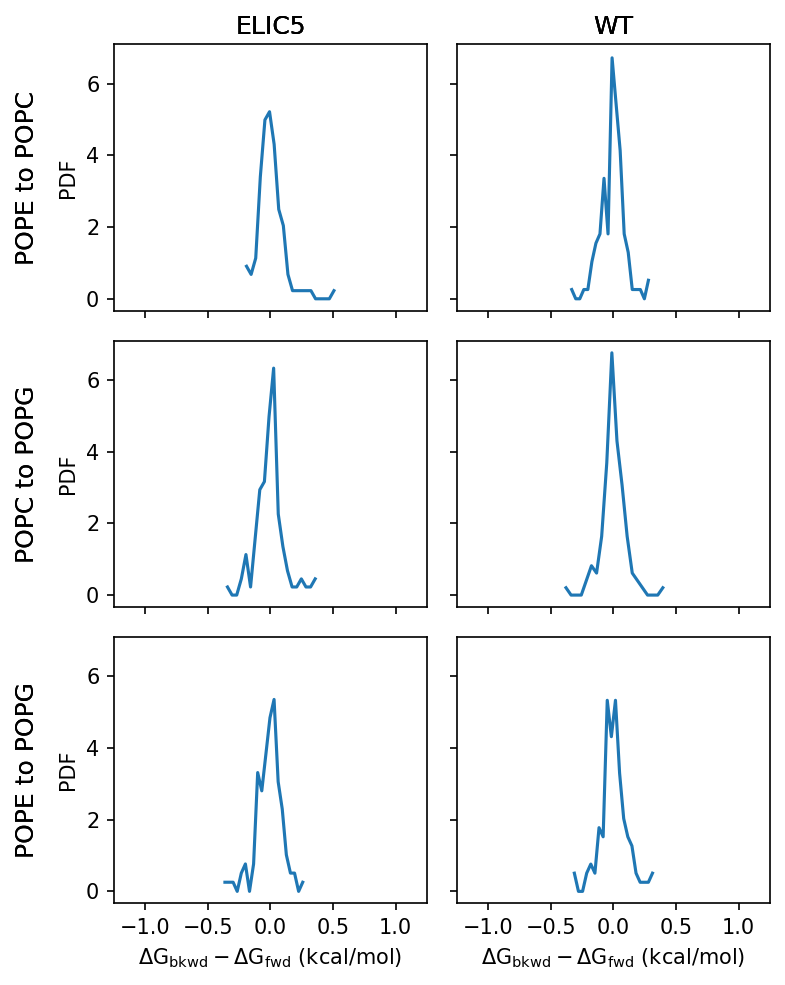

In [19]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\Delta G_{bkwd}-\Delta G_{fwd}$ (kcal/mol)', ylabel='PDF', doPlot=hysteresisPDF, sharey=True)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S3.pdf")

In [70]:
def hysteresisPlot(system, leg, keys, keyColors, theax):
    print(leg)
    perWindow = system['perWins'][leg]
    # Hysteresis plot
    #for key in keys:
        #plt.vlines(perWindow.index, np.zeros(len(perWindow)), perWindow[(key, 'dG_f')] + perWindow[(key, 'dG_b')], label=key, linewidth=2)
    diff = perWindow['diff'].iloc[:,0]*RT
    theax.plot(perWindow.index, diff, linewidth=0.5, alpha=0.8)

    #theax.plot(perWindow.index, perWindow[('mean', 'diff')]*RT, label='mean', linewidth=1.5, color='black')

    theax.set(ylim=(-1.25, 1.25))

    return theax

Now making figures for: ELIC5
PE_to_PC
Now making figures for: WT
PE_to_PC
Now making figures for: ELIC5
PC_to_PG
Now making figures for: WT
PC_to_PG
Now making figures for: ELIC5
PE_to_PG
Now making figures for: WT
PE_to_PG


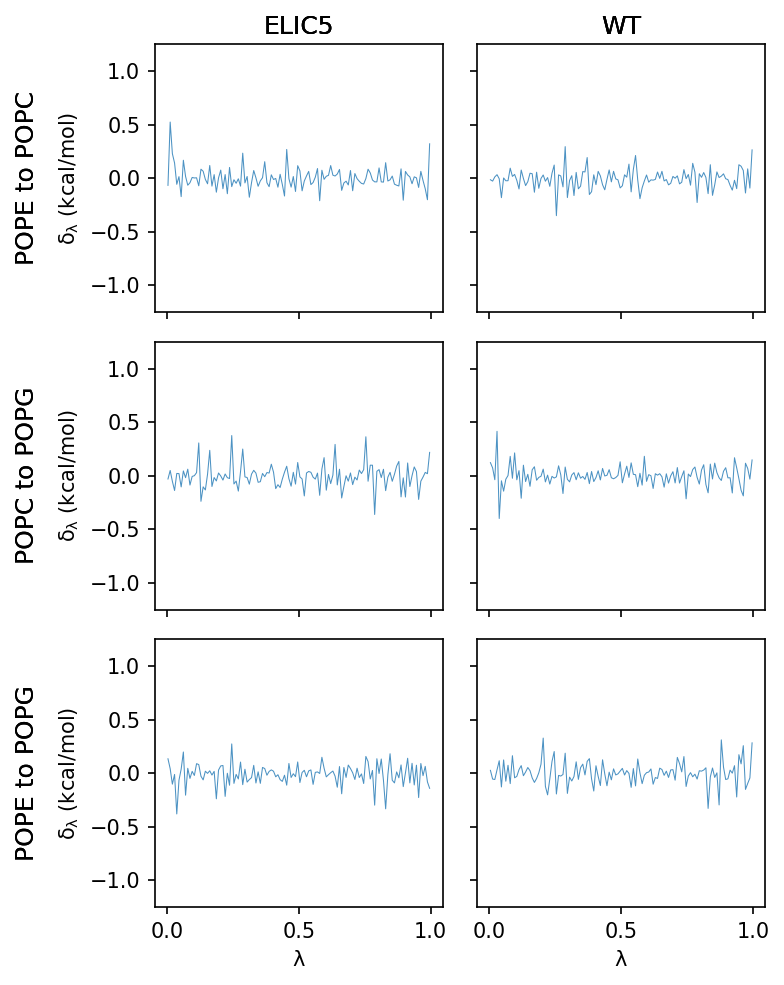

In [75]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'$\rm\delta_{\lambda}$ (kcal/mol)', doPlot=hysteresisPlot, sharey='row')
plt.savefig(f"{root}/Protein_DRAFT_altYLabel_S2.pdf")

In [85]:
def convergencePlot(system, leg, keys, keyColors, theax):
    fs = system['convergence'][leg]['forward']
    bs = system['convergence'][leg]['backward']
    theax.plot(np.arange(len(fs[l]))/len(fs[l])+0.1, np.multiply(fs, RT), marker='o', linewidth=1, markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5)
    theax.plot(np.arange(len(bs[l]))/len(fs[l])+0.1, np.multiply(bs, RT), marker='o', linewidth=1, markerfacecolor='white', markeredgewidth=1, markeredgecolor=keyColors[l], ms=5, linestyle='--')

    theax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    
    cumulative = system['cumulatives'][leg]
    finalMean = np.mean(cumulative.loc[1, (slice(None), 'f')])
    theax.axhline(y= finalMean*RT, linestyle='-.', color='gray')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', label='Forward Time Sampling')
    theax.plot(0, finalMean*RT, linewidth=1, color='black', linestyle='--', label='Backward Time Sampling')

    #theax.legend()
    
    return theax

Now making figures for: ELIC5
An error occured. Do you have bogus 'replicas'?


NameError: name 'l' is not defined

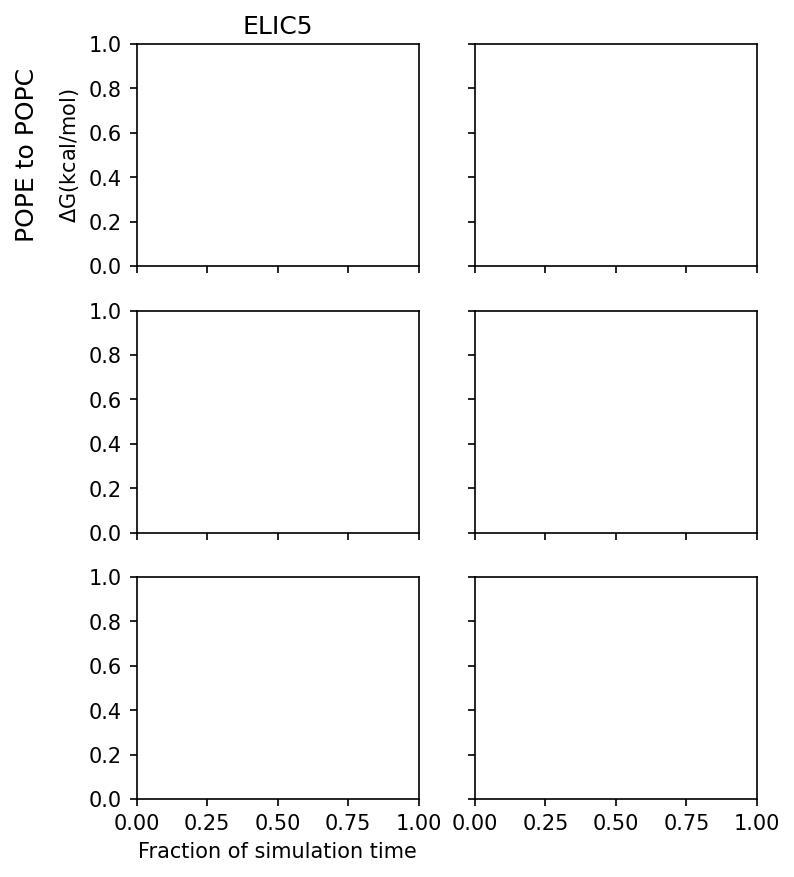

In [87]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$', doPlot=convergencePlot, sharey='row')
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S1.pdf")

In [ ]:
fig, theaxes = makePlots(allSys, systems, prefixes, xlabel='Fraction of simulation time', ylabel=r'$\rm\Delta G (kcal/mol)$', doPlot=convergencePlot, sharey='row')
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S1.pdf")

In [ ]:
fig, dGaxes = makePlots(allSys, systems, prefixes, xlabel=r'$\rm\lambda$', ylabel=r'Cumulative $\rm\Delta$G($\rm\lambda$)'+'\n (kcal/mol)', doPlot=cumulativePlot)
plt.savefig(f"{root}/Protein_DRAFT_trimmed_S4.pdf")